<a href="https://colab.research.google.com/github/Abuu254/Toxic-Comment-Classification/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas gdown

In [ ]:
 import pandas as pd
import random
# Downloading the training data
!gdown --id 1kYp9LR4wvaza-b2r3dDdH8IDRTg-3byu
data = pd.read_csv('train.csv.zip', compression='zip')
data

random.seed(42)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1kYp9LR4wvaza-b2r3dDdH8IDRTg-3byu
From (redirected): https://drive.google.com/uc?id=1kYp9LR4wvaza-b2r3dDdH8IDRTg-3byu&confirm=t&uuid=378913d4-83cf-440f-9825-f757b41c79ce
To: /Users/abuu/train.csv.zip
100%|██████████████████████████████████████| 27.6M/27.6M [00:06<00:00, 4.05MB/s]


In [ ]:
## Exploring the dataset
# Display the number of comments in the dataset
print(f"Number of comments in the dataset: {len(data)}")

# Display the balance of the labels
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = data[label_columns].sum()
print("\nNumber of comments in each category:")
print(label_counts)

# Check for missing values
missing_values = data.isnull().sum()
print("\nNumber of missing values in each column:")
print(missing_values)

Number of comments in the dataset: 159571

Number of comments in each category:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Number of missing values in each column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /Users/abuu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/abuu/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the set of stop words
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Convert to lower case and split into words
    words = text.lower().split()

    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    return " ".join(words)

# Apply the preprocessing to the comment_text column
data["comment_text"] = data["comment_text"].apply(preprocess_text)

# Display the first few rows of the preprocessed data
data.head()



[nltk_data] Downloading package omw-1.4 to /Users/abuu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/yp/mky2935s5vs3pbjfz146jnvw0000gn/T/ipykernel_70884/131507691.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/var/folders/yp/mky2935s5vs3pbjfz146jnvw0000gn/T/ipykernel_70884/131507691.py:18: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [ ]:
# !pip install tensorflow

In [ ]:
# Import the necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to keep, based on word frequency
MAX_NUM_WORDS = 20000

# Define the maximum length of a sequence
MAX_SEQ_LENGTH = 200

# Initialize a tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(data['comment_text'])

# Tokenize the text
sequences = tokenizer.texts_to_sequences(data['comment_text'])

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)

# Print the shapes
print(f'Shape of data tensor: {padded_sequences.shape}')
print(f'Shape of label tensor: {data[label_columns].shape}')



Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [ ]:
from tensorflow.keras.layers import Embedding

vocab_size = len(tokenizer.word_index) + 1 # Add 1 for padding token

# The dimension of the embedding vectors.
embedding_dim = 100

# We create an embedding layer using the Embedding class from Keras.
# input_dim is the size of the vocabulary.
# output_dim is the size of the dense vector.
# input_length is the length of input sequences.
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQ_LENGTH)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow

# Starting a new Keras Sequential model.
model = Sequential()

# Adding the embedding layer as the first layer in the model.
# This layer transforms each word index in the input sequences into a dense vector of fixed size
model.add(embedding_layer)

# Add a bidirectional LSTM layer with 64 units.
# LSTM (Long Short Term Memory) is a type of Recurrent Neural Network (RNN) that is able to learn
# and remember over long sequences and works well for many text classification tasks.
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Add another bidirectional LSTM layer.
model.add(Bidirectional(LSTM(64)))

# We use the ReLU (Rectified Linear Unit) activation function for its performance benefits.
model.add(Dense(32, activation='relu'))

# Add a dropout layer, which randomly sets a fraction (here, 50%) of the input units to 0 during
# training, which helps prevent overfitting.
model.add(Dropout(0.5))

# Add a dense output layer with 6 units (one for each label) and a sigmoid activation function.
model.add(Dense(6, activation='sigmoid'))

# Compile the model.
model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          15869900  
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [ ]:
X_train = padded_sequences # Padded sequences
y_train = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
# the batch size and the number of epochs to use during training.
batch_size = 128
epochs = 5

# Train the model. We use the fit method and provide our training data and labels as arguments.
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
1122/1122 [==============================] - 451s 400ms/step - loss: 0.0865 - accuracy: 0.7765 - val_loss: 0.0546 - val_accuracy: 0.9940
Epoch 2/5
1122/1122 [==============================] - 452s 403ms/step - loss: 0.0516 - accuracy: 0.9762 - val_loss: 0.0523 - val_accuracy: 0.9940
Epoch 3/5
1122/1122 [==============================] - 446s 397ms/step - loss: 0.0463 - accuracy: 0.9886 - val_loss: 0.0550 - val_accuracy: 0.9940
Epoch 4/5
1122/1122 [==============================] - 443s 395ms/step - loss: 0.0424 - accuracy: 0.9928 - val_loss: 0.0581 - val_accuracy: 0.9940
Epoch 5/5
1122/1122 [==============================] - 437s 389ms/step - loss: 0.0390 - accuracy: 0.9927 - val_loss: 0.0642 - val_accuracy: 0.9940


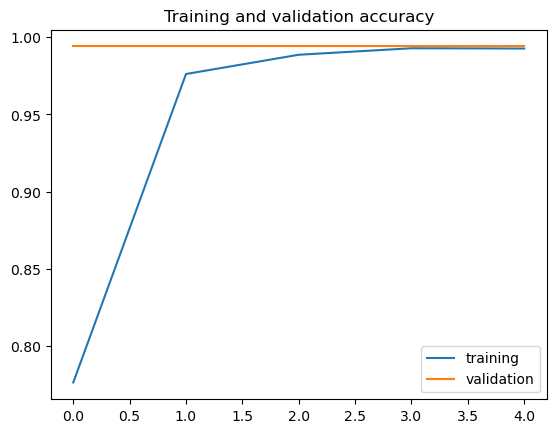

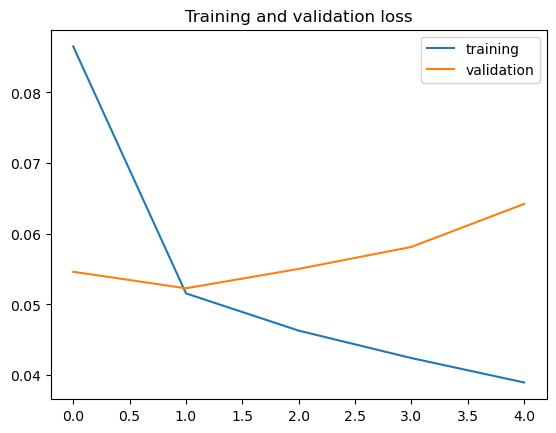

In [ ]:
# Let's plot the training history to see how the model performed during each epoch of the training process.
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training')
plt.plot(epochs, val_acc, label='validation')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.title('Training and validation loss')
plt.legend()


In [ ]:
# Download test.csv.zip
!gdown --id 1mRa7HjQYw94VK7eH7efMEhs2WOSC3yhX

# Download test_labels.csv.zip
!gdown --id 1NZYQBghYSKNXfklf1bQ_njQdO-oDuWOT

/Users/abuu/anaconda3/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mRa7HjQYw94VK7eH7efMEhs2WOSC3yhX
To: /Users/abuu/test.csv.zip
100%|██████████████████████████████████████| 24.6M/24.6M [00:05<00:00, 4.67MB/s]
/Users/abuu/anaconda3/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NZYQBghYSKNXfklf1bQ_njQdO-oDuWOT
To: /Users/abuu/test_labels.csv.zip
100%|██████████████████████████████████████| 1.53M/1.53M [00:00<00:00, 5.98MB/s]


In [ ]:
# Unzip the files
# !unzip test.csv.zip
# !unzip test_labels.csv.zip

# Use pandas to read the csv files
import pandas as pd

test_data = pd.read_csv('test.csv.zip', compression="zip")
test_labels = pd.read_csv('test_labels.csv.zip', compression="zip")


In [ ]:
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [ ]:
# Merge the test data and test labels on the 'id' column
merged_test_data = pd.merge(test_data, test_labels, on='id')

# Filter out the rows where the labels are -1 (these are not used for scoring)
filtered_test_data = merged_test_data[merged_test_data['toxic'] != -1]

# Separate the comments and labels
test_comments = filtered_test_data['comment_text']
test_labels = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [ ]:
len(test_labels)

63978

In [ ]:
len(test_comments)

63978

In [ ]:
# Tokenize and pad the test comments
test_sequences = tokenizer.texts_to_sequences(test_comments)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH)

# Convert the test labels to a numpy array
test_labels = test_labels.to_numpy()


In [ ]:
test_labels
len(test_labels)

63978

In [ ]:
padded_test_sequences
len(padded_test_sequences)

63978

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(padded_test_sequences, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2000/2000 [==============================] - 66s 33ms/step - loss: 0.1452 - accuracy: 0.9976
Test Loss: 0.14522749185562134
Test Accuracy: 0.9976085424423218


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Make predictions on the test data
y_pred_prob = model.predict(padded_test_sequences)

# Threshold the probabilities to get class predictions
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate and print the classification report
print(classification_report(test_labels, y_pred, zero_division=1))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

2000/2000 [==============================] - 67s 34ms/step
              precision    recall  f1-score   support

           0       0.41      0.73      0.52      6090
           1       1.00      0.00      0.00       367
           2       0.43      0.70      0.53      3691
           3       1.00      0.00      0.00       211
           4       0.37      0.62      0.46      3427
           5       1.00      0.00      0.00       712

   micro avg       0.40      0.63      0.49     14498
   macro avg       0.70      0.34      0.25     14498
weighted avg       0.46      0.63      0.46     14498
 samples avg       0.89      0.96      0.86     14498

ROC AUC Score: 0.9165917710639914


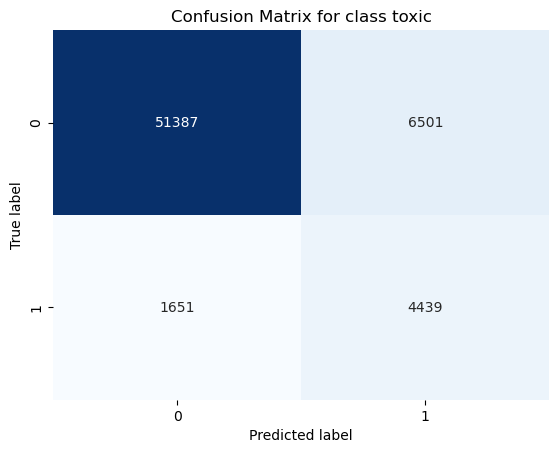

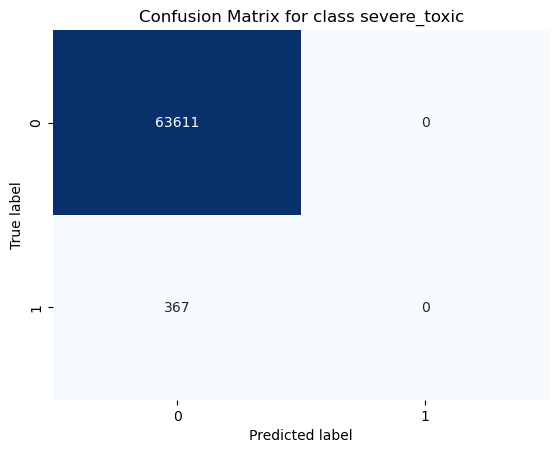

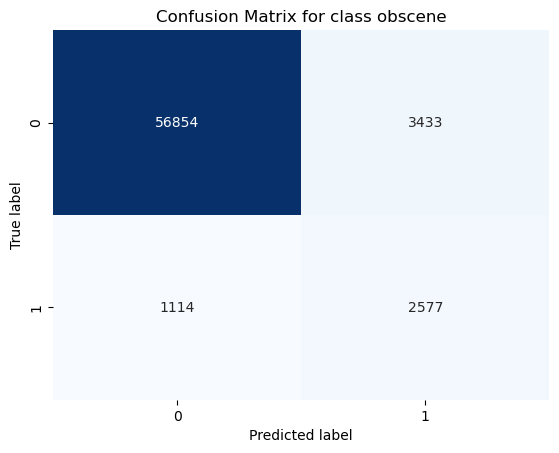

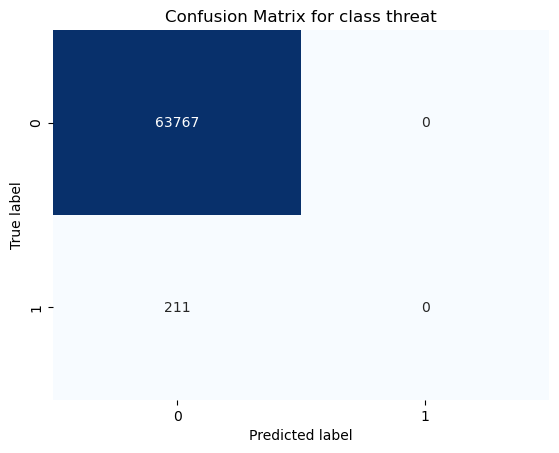

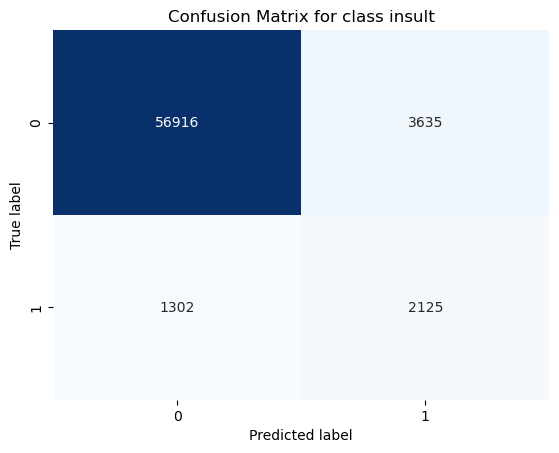

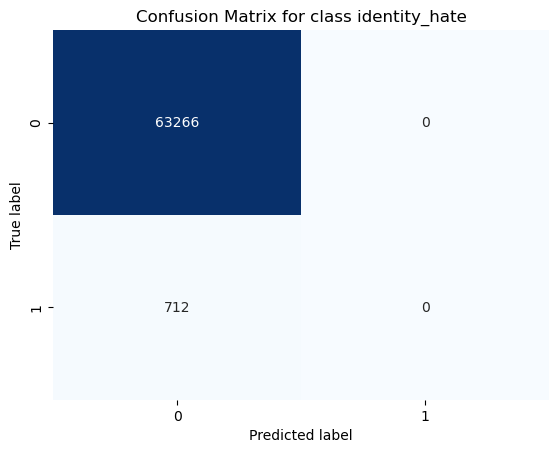

In [ ]:
# List of class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(test_labels, y_pred)

# Plot confusion matrix for each class
for i, matrix in enumerate(cm):
    plt.figure()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for class {class_names[i]}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


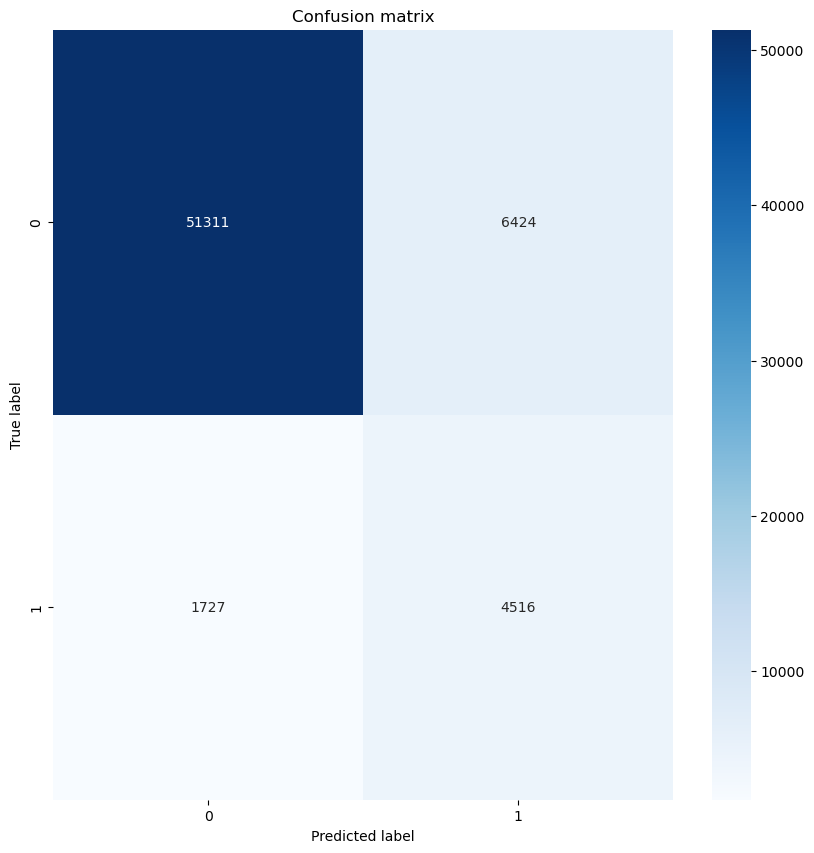

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert multi-label to binary
binary_test_labels = np.where(test_labels.sum(axis=1) > 0, 1, 0)
binary_pred_labels = np.where(y_pred.sum(axis=1) > 0, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(binary_test_labels, binary_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


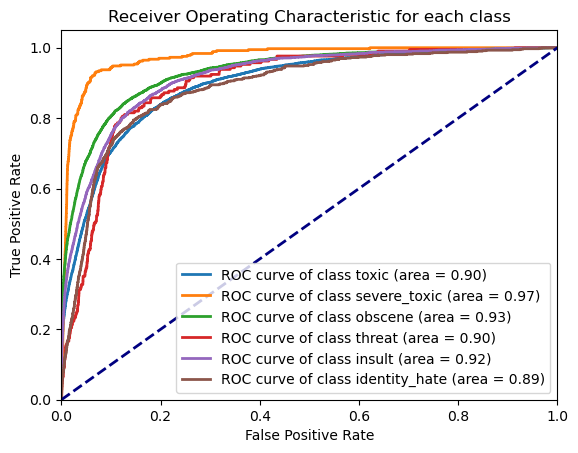

In [ ]:
from sklearn.metrics import roc_curve, auc

# Define class labels
class_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Initialize figure
plt.figure()

# Iterate over each class
for i in range(test_labels.shape[1]):
    fpr, tpr, _ = roc_curve(test_labels[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc))

# Plot random guess line.
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Define limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")

# Show plot
plt.show()

In [ ]:
while True:
    # Get user input
    user_input = input("\nPlease enter your comment or type 'exit' to quit: ")

    # Break the loop if the user types 'exit'
    if user_input.lower() == 'exit':
        break

    # Preprocess the text
    user_input = preprocess_text(user_input)

    # Tokenize and pad the text
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    user_input_padded = pad_sequences(user_input_sequence, maxlen=MAX_SEQ_LENGTH)

    # Use the model to predict the toxicity
    user_input_prediction = model.predict(user_input_padded)

    # Check if the comment is toxic
    toxic_threshold = 0.5
    is_toxic = user_input_prediction > toxic_threshold

    if is_toxic.any():
        print("The comment is likely to be toxic.")
        toxic_classes = np.array(label_columns)[is_toxic[0]]
        print("The predicted classes of toxicity are:", ', '.join(toxic_classes))
    else:
        print("The comment is likely to be not toxic.")



Please enter your comment or type 'exit' to quit: you are not good
1/1 [==============================] - 0s 25ms/step
The comment is likely to be not toxic.

Please enter your comment or type 'exit' to quit: You are a worthless piece of trash and I hope you know that.
1/1 [==============================] - 0s 23ms/step
The comment is likely to be toxic.
The predicted classes of toxicity are: toxic, obscene, insult

Please enter your comment or type 'exit' to quit: Your insights on the topic are really enlightening.
1/1 [==============================] - 0s 23ms/step
The comment is likely to be not toxic.

Please enter your comment or type 'exit' to quit: Shut up, you're so annoying.
1/1 [==============================] - 0s 33ms/step
The comment is likely to be toxic.
The predicted classes of toxicity are: toxic
